<p align="center">
  <img width="550" height="281" src="http://encuentratubeca.mx/wp-content/uploads/2019/04/logoudgvectores_1_origsdaasss.png">
</p>

# <center>Proyecto Final de la materia Desarrollo de Proyecto II</center>             
------
## Maestría en Ciencia de los Datos
#### Alberto Martínez Lara
#### Mauricio Arnoldo Tenorio Vargas

#### Mayo 2023

In [1]:
# Importamos librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import altair as alt
import nltk
from wordcloud import WordCloud, ImageColorGenerator
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacytextblob.spacytextblob import SpacyTextBlob
from PIL import Image

In [2]:
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

#### Informacion del Dataset
Dataset utilizando 

Variables:

* text: Contenido del tweet.
* favorited: .
* favoriteCount: Conteo de veces que el tweet fue marcado con favorito por otro usuario.
* replyToSN: Contenido del tweet, r.
* created: Fecha, hora y minuto de creación del tweet.
* truncated: Indicador de si el Tweet fue truncado al momento de obtenerlo con el API.
* replyToSID: .
* id: Identificador del tweet.
* replyToUID: .
* statusSource: html source.
* screenName: Usuario.
* retweetCount: Numero de retweets.
* isRetweet: Indicador de si el tweet es un Retweet o Tweet regular..
* retweeted: Indicador de si el tweet fue retweeteado.
* longitude: longitud del origen del tweet.
* latitude: latitud del origen del tweet.

In [3]:
#Descargamos dataset directamente desde el url
path = "../data/GPT.csv"
df = pd.read_csv(path)

In [4]:
df.head()

text  favorited  \
0  RT @gdb: ChatGPT as a tool for Congress: https...      False   
1  RT @gdb: ChatGPT as a tool for Congress: https...      False   
2  RT @moemicky18: So chatgpt failed an accountin...      False   
3  RT @JeanPROFITbiz: Les gens gagnent des millie...      False   
4  does chatgpt mean I, as a wet lab biologist wh...      False   

   favoriteCount replyToSN             created  truncated  replyToSID  \
0              0       NaN  4/27/2023 17:35:29      False         NaN   
1              0       NaN  4/27/2023 17:35:28      False         NaN   
2              0       NaN  4/27/2023 17:35:27      False         NaN   
3              0       NaN  4/27/2023 17:35:27      False         NaN   
4              0       NaN  4/27/2023 17:35:26       True         NaN   

                    id  replyToUID  \
0  1651641228520194048         NaN   
1  1651641223428317185         NaN   
2  1651641221893308416         NaN   
3  1651641218059608094         NaN   
4  1651641214557364234         NaN   

                                        statusSource   screenName  \
0  <a href="http://twitter.com/download/iphone" r...      nos_ult   
1  <a href="http://twitter.com/download/android" ...  verobouvier   
2  <a href="http://twitter.com/download/iphone" r...     uzayrmug   
3  <a href="http://twitter.com/download/iphone" r...    SachaMery   
4  <a href="http://twitter.com/download/android" ...   ruth_hook_   

   retweetCount  isRetweet  retweeted  longitude  latitude  
0            58       True      False        NaN       NaN  
1            58       True      False        NaN       NaN  
2             2       True      False        NaN       NaN  
3           359       True      False        NaN       NaN  
4             0      False      False        NaN       NaN

In [5]:
df.shape

(3000, 16)

Elminaremos variables inecesarias para el analisis.

In [6]:
df = df.drop(['replyToSID', 'id', 'replyToUID', 'longitude', 'latitude', 'replyToSN'], axis=1)

In [7]:
df.shape

(3000, 10)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           3000 non-null   object
 1   favorited      3000 non-null   bool  
 2   favoriteCount  3000 non-null   int64 
 3   created        3000 non-null   object
 4   truncated      3000 non-null   bool  
 5   statusSource   3000 non-null   object
 6   screenName     3000 non-null   object
 7   retweetCount   3000 non-null   int64 
 8   isRetweet      3000 non-null   bool  
 9   retweeted      3000 non-null   bool  
dtypes: bool(4), int64(2), object(4)
memory usage: 152.5+ KB


### EDA & Data Cleaning

In [9]:
df.isnull().sum()

text             0
favorited        0
favoriteCount    0
created          0
truncated        0
statusSource     0
screenName       0
retweetCount     0
isRetweet        0
retweeted        0
dtype: int64

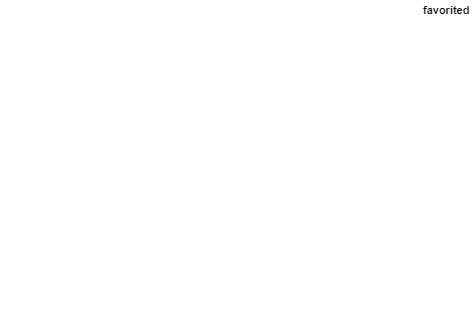

In [10]:
alt.Chart(df).mark_arc().encode(
    theta = alt.Theta(field='count(favorited):Q',type='quantitative'),
    color=alt.Color(field='favorited', type="nominal"),
)

Sólo hay valores "FALSE" en la columna 'favorited', por lo que procedemos a eliminar dicha columna del dataframe.

In [11]:
df = df.drop(['favorited'], axis=1)

Distribución por 'Hour created'

In [12]:
df['createdHour'] = df.created.str[9:12]
df.createdHour

0        17
1        17
2        17
3        17
4        17
       ... 
2995     16
2996     16
2997     16
2998     16
2999     16
Name: createdHour, Length: 3000, dtype: object

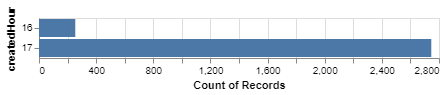

In [13]:
#alt.renderers.enable("mimetype")
alt.Chart(df).mark_bar().encode(
    y = 'createdHour',
    x = 'count(createdHour):Q'
)

### Preprocesamiento de texto

#### 1. Extraer columna con texto del tweet

In [14]:
df_texto = df['text']
df_texto = pd.DataFrame(df_texto)
df_texto

text
0     RT @gdb: ChatGPT as a tool for Congress: https...
1     RT @gdb: ChatGPT as a tool for Congress: https...
2     RT @moemicky18: So chatgpt failed an accountin...
3     RT @JeanPROFITbiz: Les gens gagnent des millie...
4     does chatgpt mean I, as a wet lab biologist wh...
...                                                 ...
2995  RT @arabtribunenews: د. فراس الحربي يكتب: ثورة...
2996  I actually had to redo this one twice because ...
2997  RT @rodtrent: Can ChatGPT work with your enter...
2998  RT @rowancheung: 2. Boston Dynamics puts ChatG...
2999  RT @Naho_May: J’ai demandé à ChatGPT des conse...

[3000 rows x 1 columns]

#### 2. Detectar idioma original y traducir al inglés

In [15]:
from langdetect import detect

for index, row in df_texto['text'].iteritems():
    try:
        lang = detect(row) #detecting each row
        df_texto.loc[index, 'idioma'] = lang
    except:
        continue

df_texto

text idioma
0     RT @gdb: ChatGPT as a tool for Congress: https...     en
1     RT @gdb: ChatGPT as a tool for Congress: https...     en
2     RT @moemicky18: So chatgpt failed an accountin...     en
3     RT @JeanPROFITbiz: Les gens gagnent des millie...     fr
4     does chatgpt mean I, as a wet lab biologist wh...     en
...                                                 ...    ...
2995  RT @arabtribunenews: د. فراس الحربي يكتب: ثورة...     ar
2996  I actually had to redo this one twice because ...     en
2997  RT @rodtrent: Can ChatGPT work with your enter...     en
2998  RT @rowancheung: 2. Boston Dynamics puts ChatG...     en
2999  RT @Naho_May: J’ai demandé à ChatGPT des conse...     fr

[3000 rows x 2 columns]

In [16]:
from deep_translator import GoogleTranslator

for index, row in df_texto['text'].iteritems():
    try:
        translation = GoogleTranslator(source='auto', target='en').translate(row) #detecting each row
        df_texto.loc[index, 'text_ingles'] = translation
    except:
        continue

df_texto

text idioma  \
0     RT @gdb: ChatGPT as a tool for Congress: https...     en   
1     RT @gdb: ChatGPT as a tool for Congress: https...     en   
2     RT @moemicky18: So chatgpt failed an accountin...     en   
3     RT @JeanPROFITbiz: Les gens gagnent des millie...     fr   
4     does chatgpt mean I, as a wet lab biologist wh...     en   
...                                                 ...    ...   
2995  RT @arabtribunenews: د. فراس الحربي يكتب: ثورة...     ar   
2996  I actually had to redo this one twice because ...     en   
2997  RT @rodtrent: Can ChatGPT work with your enter...     en   
2998  RT @rowancheung: 2. Boston Dynamics puts ChatG...     en   
2999  RT @Naho_May: J’ai demandé à ChatGPT des conse...     fr   

                                            text_ingles  
0     RT @gdb: ChatGPT as a tool for Congress: https...  
1     RT @gdb: ChatGPT as a tool for Congress: https...  
2     RT @moemicky18: So chatgpt failed an accountin...  
3     RT @JeanPROFITbiz: People are making thousands...  
4     does chatgpt mean I, as a wet lab biologist wh...  
...                                                 ...  
2995  RT @arabtribunenews: Dr. Firas Al-Harbi writes...  
2996  I actually had to redo this one twice because ...  
2997  RT @rodtrent: Can ChatGPT work with your enter...  
2998  RT @rowancheung: 2. Boston Dynamics puts ChatG...  
2999  RT @Naho_May: I asked ChatGPT for advice on fi...  

[3000 rows x 3 columns]

#### 3. Eliminar signos de puntuación
Con excepción de # y @ para identificar hashtags y cuentas.

In [17]:
import string
signos_puntuacion = string.punctuation
signos_puntuacion = signos_puntuacion.replace("#", "")  # quitar '#' de hashtags 
signos_puntuacion = signos_puntuacion.replace("@", "")  # quitar '@' de cuentas
signos_puntuacion

'!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~'

In [18]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in signos_puntuacion])
    return punctuationfree

#almacenar texto sin signos de puntuación
df_texto['text_clean'] = df_texto['text_ingles'].apply(lambda x:remove_punctuation(x))
df_texto.head()

text idioma  \
0  RT @gdb: ChatGPT as a tool for Congress: https...     en   
1  RT @gdb: ChatGPT as a tool for Congress: https...     en   
2  RT @moemicky18: So chatgpt failed an accountin...     en   
3  RT @JeanPROFITbiz: Les gens gagnent des millie...     fr   
4  does chatgpt mean I, as a wet lab biologist wh...     en   

                                         text_ingles  \
0  RT @gdb: ChatGPT as a tool for Congress: https...   
1  RT @gdb: ChatGPT as a tool for Congress: https...   
2  RT @moemicky18: So chatgpt failed an accountin...   
3  RT @JeanPROFITbiz: People are making thousands...   
4  does chatgpt mean I, as a wet lab biologist wh...   

                                          text_clean  
0  RT @gdb ChatGPT as a tool for Congress httpstc...  
1  RT @gdb ChatGPT as a tool for Congress httpstc...  
2  RT @moemicky18 So chatgpt failed an accounting...  
3  RT @JeanPROFITbiz People are making thousands ...  
4  does chatgpt mean I as a wet lab biologist who...

#### 4. Cambiar texto a minúsculas

In [19]:
df_texto['text_clean'] = df_texto['text_clean'].apply((lambda x: x.lower()))
df_texto.head()

text idioma  \
0  RT @gdb: ChatGPT as a tool for Congress: https...     en   
1  RT @gdb: ChatGPT as a tool for Congress: https...     en   
2  RT @moemicky18: So chatgpt failed an accountin...     en   
3  RT @JeanPROFITbiz: Les gens gagnent des millie...     fr   
4  does chatgpt mean I, as a wet lab biologist wh...     en   

                                         text_ingles  \
0  RT @gdb: ChatGPT as a tool for Congress: https...   
1  RT @gdb: ChatGPT as a tool for Congress: https...   
2  RT @moemicky18: So chatgpt failed an accountin...   
3  RT @JeanPROFITbiz: People are making thousands...   
4  does chatgpt mean I, as a wet lab biologist wh...   

                                          text_clean  
0  rt @gdb chatgpt as a tool for congress httpstc...  
1  rt @gdb chatgpt as a tool for congress httpstc...  
2  rt @moemicky18 so chatgpt failed an accounting...  
3  rt @jeanprofitbiz people are making thousands ...  
4  does chatgpt mean i as a wet lab biologist who...

#### 5. Tokenización

In [20]:
df_texto['text_clean'] = df_texto['text_clean'].apply(lambda x: x.rsplit())
df_texto.head()

text idioma  \
0  RT @gdb: ChatGPT as a tool for Congress: https...     en   
1  RT @gdb: ChatGPT as a tool for Congress: https...     en   
2  RT @moemicky18: So chatgpt failed an accountin...     en   
3  RT @JeanPROFITbiz: Les gens gagnent des millie...     fr   
4  does chatgpt mean I, as a wet lab biologist wh...     en   

                                         text_ingles  \
0  RT @gdb: ChatGPT as a tool for Congress: https...   
1  RT @gdb: ChatGPT as a tool for Congress: https...   
2  RT @moemicky18: So chatgpt failed an accountin...   
3  RT @JeanPROFITbiz: People are making thousands...   
4  does chatgpt mean I, as a wet lab biologist wh...   

                                          text_clean  
0  [rt, @gdb, chatgpt, as, a, tool, for, congress...  
1  [rt, @gdb, chatgpt, as, a, tool, for, congress...  
2  [rt, @moemicky18, so, chatgpt, failed, an, acc...  
3  [rt, @jeanprofitbiz, people, are, making, thou...  
4  [does, chatgpt, mean, i, as, a, wet, lab, biol...

#### 6. Eliminar stopwords

In [21]:
stopwords = nltk.corpus.stopwords.words('english')

print("Número de stopwords en de NLTK library:", len(stopwords))
stopwords[:15]

Número de stopwords en de NLTK library: 179


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours']

In [22]:
# función para remover stopwords del texto tokenizado
def remove_stopwords(text):
    output= [i for i in text if i not in stopwords]
    return output

df_texto['text_clean'] = df_texto['text_clean'].apply(lambda x:remove_stopwords(x))
df_texto.head()

text idioma  \
0  RT @gdb: ChatGPT as a tool for Congress: https...     en   
1  RT @gdb: ChatGPT as a tool for Congress: https...     en   
2  RT @moemicky18: So chatgpt failed an accountin...     en   
3  RT @JeanPROFITbiz: Les gens gagnent des millie...     fr   
4  does chatgpt mean I, as a wet lab biologist wh...     en   

                                         text_ingles  \
0  RT @gdb: ChatGPT as a tool for Congress: https...   
1  RT @gdb: ChatGPT as a tool for Congress: https...   
2  RT @moemicky18: So chatgpt failed an accountin...   
3  RT @JeanPROFITbiz: People are making thousands...   
4  does chatgpt mean I, as a wet lab biologist wh...   

                                          text_clean  
0  [rt, @gdb, chatgpt, tool, congress, httpstcohl...  
1  [rt, @gdb, chatgpt, tool, congress, httpstcohl...  
2  [rt, @moemicky18, chatgpt, failed, accounting,...  
3  [rt, @jeanprofitbiz, people, making, thousands...  
4  [chatgpt, mean, wet, lab, biologist, frankenst...

#### 7. Lematización

In [23]:
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()

# función para lematizar
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

df_texto['text_clean'] = df_texto['text_clean'].apply(lambda x:lemmatizer(x))
df_texto.head()

text idioma  \
0  RT @gdb: ChatGPT as a tool for Congress: https...     en   
1  RT @gdb: ChatGPT as a tool for Congress: https...     en   
2  RT @moemicky18: So chatgpt failed an accountin...     en   
3  RT @JeanPROFITbiz: Les gens gagnent des millie...     fr   
4  does chatgpt mean I, as a wet lab biologist wh...     en   

                                         text_ingles  \
0  RT @gdb: ChatGPT as a tool for Congress: https...   
1  RT @gdb: ChatGPT as a tool for Congress: https...   
2  RT @moemicky18: So chatgpt failed an accountin...   
3  RT @JeanPROFITbiz: People are making thousands...   
4  does chatgpt mean I, as a wet lab biologist wh...   

                                          text_clean  
0  [rt, @gdb, chatgpt, tool, congress, httpstcohl...  
1  [rt, @gdb, chatgpt, tool, congress, httpstcohl...  
2  [rt, @moemicky18, chatgpt, failed, accounting,...  
3  [rt, @jeanprofitbiz, people, making, thousand,...  
4  [chatgpt, mean, wet, lab, biologist, frankenst...

#### 8. Eliminar URL's

In [24]:
# función para eliminar URL's
def erase_urls(text):
    output = [i for i in text if i.rfind("http")==-1]
    return output

df_texto['text_clean'] = df_texto['text_clean'].apply(lambda x:erase_urls(x))
df_texto.head()

text idioma  \
0  RT @gdb: ChatGPT as a tool for Congress: https...     en   
1  RT @gdb: ChatGPT as a tool for Congress: https...     en   
2  RT @moemicky18: So chatgpt failed an accountin...     en   
3  RT @JeanPROFITbiz: Les gens gagnent des millie...     fr   
4  does chatgpt mean I, as a wet lab biologist wh...     en   

                                         text_ingles  \
0  RT @gdb: ChatGPT as a tool for Congress: https...   
1  RT @gdb: ChatGPT as a tool for Congress: https...   
2  RT @moemicky18: So chatgpt failed an accountin...   
3  RT @JeanPROFITbiz: People are making thousands...   
4  does chatgpt mean I, as a wet lab biologist wh...   

                                          text_clean  
0                [rt, @gdb, chatgpt, tool, congress]  
1                [rt, @gdb, chatgpt, tool, congress]  
2  [rt, @moemicky18, chatgpt, failed, accounting,...  
3  [rt, @jeanprofitbiz, people, making, thousand,...  
4  [chatgpt, mean, wet, lab, biologist, frankenst...

### Resultado final preprocesamiento

In [25]:
df_texto[['text','text_clean']]

text  \
0     RT @gdb: ChatGPT as a tool for Congress: https...   
1     RT @gdb: ChatGPT as a tool for Congress: https...   
2     RT @moemicky18: So chatgpt failed an accountin...   
3     RT @JeanPROFITbiz: Les gens gagnent des millie...   
4     does chatgpt mean I, as a wet lab biologist wh...   
...                                                 ...   
2995  RT @arabtribunenews: د. فراس الحربي يكتب: ثورة...   
2996  I actually had to redo this one twice because ...   
2997  RT @rodtrent: Can ChatGPT work with your enter...   
2998  RT @rowancheung: 2. Boston Dynamics puts ChatG...   
2999  RT @Naho_May: J’ai demandé à ChatGPT des conse...   

                                             text_clean  
0                   [rt, @gdb, chatgpt, tool, congress]  
1                   [rt, @gdb, chatgpt, tool, congress]  
2     [rt, @moemicky18, chatgpt, failed, accounting,...  
3     [rt, @jeanprofitbiz, people, making, thousand,...  
4     [chatgpt, mean, wet, lab, biologist, frankenst...  
...                                                 ...  
2995  [rt, @arabtribunenews, dr, firas, alharbi, wri...  
2996  [actually, redo, one, twice, chatgpt, kept, gi...  
2997  [rt, @rodtrent, chatgpt, work, enterprise, dat...  
2998  [rt, @rowancheung, 2, boston, dynamic, put, ch...  
2999  [rt, @nahomay, asked, chatgpt, advice, fishing...  

[3000 rows x 2 columns]

#### Guardar resultados

In [26]:
df_texto.to_csv("../results/result_preprocesamiento_chatgpt.csv")

### Análisis de sentimiento

In [27]:
df = pd.read_csv("../results/result_preprocesamiento_chatgpt.csv")
df_texto = pd.DataFrame(df[['text_clean','idioma']])

comillas = ('\'')

def remover_comillas(text):
    punctuationfree="".join([i for i in text if i not in comillas])
    return punctuationfree

#almacenar texto sin signos de puntuación
df_texto['text_clean'] = df_texto['text_clean'].apply(lambda x:remover_comillas(x))
df_texto

text_clean idioma
0                   [rt, @gdb, chatgpt, tool, congress]     en
1                   [rt, @gdb, chatgpt, tool, congress]     en
2     [rt, @moemicky18, chatgpt, failed, accounting,...     en
3     [rt, @jeanprofitbiz, people, making, thousand,...     fr
4     [chatgpt, mean, wet, lab, biologist, frankenst...     en
...                                                 ...    ...
2995  [rt, @arabtribunenews, dr, firas, alharbi, wri...     ar
2996  [actually, redo, one, twice, chatgpt, kept, gi...     en
2997  [rt, @rodtrent, chatgpt, work, enterprise, dat...     en
2998  [rt, @rowancheung, 2, boston, dynamic, put, ch...     en
2999  [rt, @nahomay, asked, chatgpt, advice, fishing...     fr

[3000 rows x 2 columns]

In [28]:
# Texto en inglés
nlp = spacy.load("en_core_web_sm")

# Añadir análisis de sentimiento
nlp.add_pipe("spacytextblob")

df_sent = pd.DataFrame()

for i in range(len(df_texto)):
    doc = nlp(df_texto.iloc[i]['text_clean'])
    idioma = df_texto.iloc[i]['idioma']
    df_1 = pd.DataFrame({
        "clean_tweet":doc.text,
        "polarity":doc._.blob.polarity,
        "subjectivity":doc._.blob.subjectivity,
        "language":idioma
    }, index=[0])
    df_sent = pd.concat([df_sent, df_1])
    
df_sent

clean_tweet  polarity  subjectivity  \
0                 [rt, @gdb, chatgpt, tool, congress]   0.00000      0.000000   
0                 [rt, @gdb, chatgpt, tool, congress]   0.00000      0.000000   
0   [rt, @moemicky18, chatgpt, failed, accounting,...  -0.35000      0.350000   
0   [rt, @jeanprofitbiz, people, making, thousand,...   0.00000      0.000000   
0   [chatgpt, mean, wet, lab, biologist, frankenst...  -0.20625      0.543750   
..                                                ...       ...           ...   
0   [rt, @arabtribunenews, dr, firas, alharbi, wri...   0.00000      0.000000   
0   [actually, redo, one, twice, chatgpt, kept, gi...   0.00000      0.100000   
0   [rt, @rodtrent, chatgpt, work, enterprise, dat...   0.00000      0.000000   
0   [rt, @rowancheung, 2, boston, dynamic, put, ch...   0.00000      0.166667   
0   [rt, @nahomay, asked, chatgpt, advice, fishing...   0.45000      0.761111   

   language  
0        en  
0        en  
0        en  
0        fr  
0        en  
..      ...  
0        ar  
0        en  
0        en  
0        en  
0        fr  

[3000 rows x 4 columns]

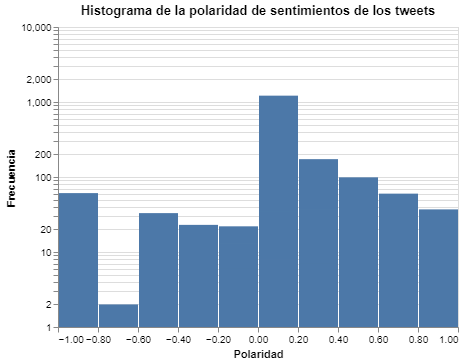

In [29]:
# Gráfico polaridad
alt.Chart(df_sent).mark_bar().encode(
    alt.X('polarity', bin=True, title="Polaridad"),
    alt.Y('count()', scale=alt.Scale(type="log"), title="Frecuencia"),
    tooltip=['polarity', 'count()']
).properties(
    title="Histograma de la polaridad de sentimientos de los tweets"
)

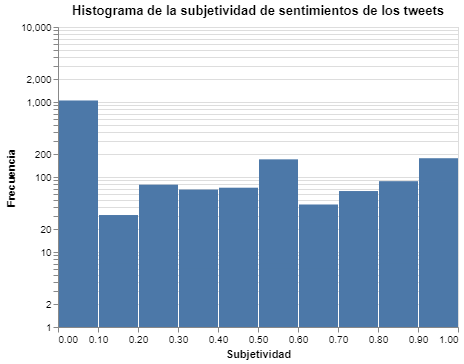

In [30]:
# Gráfico subjetividad
alt.Chart(df_sent).mark_bar().encode(
    alt.X('subjectivity', bin=True, title="Subjetividad"),
    alt.Y('count()', scale=alt.Scale(type="log"), title="Frecuencia"),
    tooltip=['subjectivity', 'count()']
).properties(
    title="Histograma de la subjetividad de sentimientos de los tweets"
)

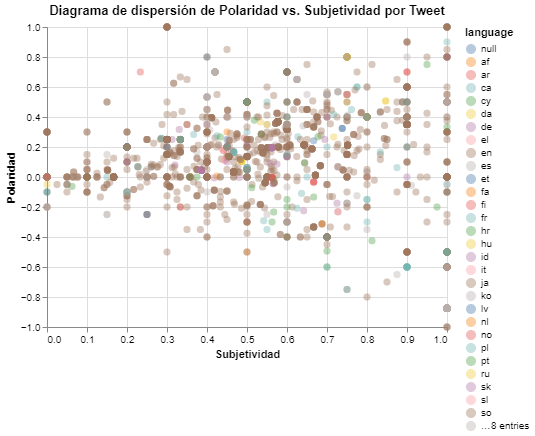

In [31]:
# Polaridad vs. subjetividad
alt.Chart(df_sent).mark_circle(opacity=.4, size=50).encode(
    alt.X('subjectivity:Q', title="Subjetividad"),
    alt.Y('polarity:Q', title="Polaridad"),
    alt.Color('language'),
    tooltip=['clean_tweet','polarity','subjectivity']
).properties(
    title="Diagrama de dispersión de Polaridad vs. Subjetividad por Tweet"
)

In [32]:
df_sent['language'].unique()

array(['en', 'fr', 'sq', 'ar', 'ja', 'es', 'pl', 'zh-cn', 'it', 'tr',
       'pt', 'id', 'ko', 'th', 'de', 'vi', 'af', 'no', 'lv', nan, 'ru',
       'ur', 'nl', 'da', 'so', 'ca', 'et', 'hr', 'sw', 'sl', 'fi', 'fa',
       'cy', 'tl', 'sk', 'hu', 'el'], dtype=object)

### Nube de palabras

(-0.5, 795.5, 737.5, -0.5)

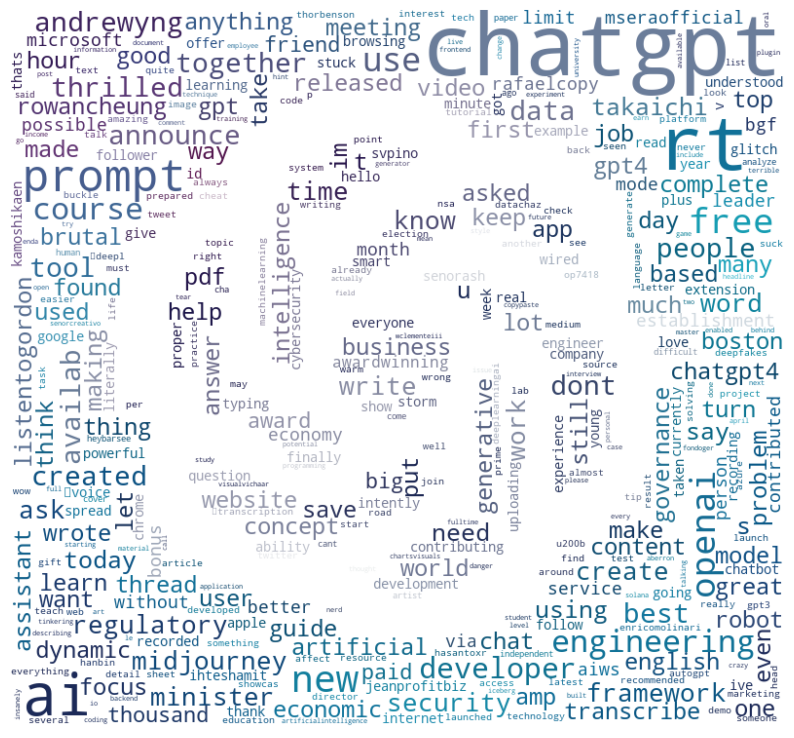

In [33]:
mask = np.array(Image.open('../data/ChatGPT_logo4.png'))

wcloud = WordCloud(width=3000, height=1700, random_state=11, max_font_size=211, 
                   background_color='white', max_words=400, collocations=False, 
                   mode='RGBA',mask=mask).generate(" ".join(df_texto['text_clean']))

plt.figure(figsize=(10,10))
image_colors = ImageColorGenerator(mask)
plt.imshow(wcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

### Fuentes:

- [Cómo detectar y traducir múltiples idiomas para un proyecto de PLN (NLP)](https://www.ibidem-translations.com/edu/traduccion-idiomas-nlp/#:~:text=La%20función%20“detectar”%20y%20“traducir”%20de%20Python&text=Luego%20detecta%20el%20idioma%20del,proporcionado%20al%20idioma%20de%20destino.)
- [Deep Translator](https://pypi.org/project/deep-translator/)
- [Material del curso Desarrollo de Proyectos II](https://github.com/vcuspinera/UDG_MCD_Project_Dev_II)
- [Actividad 11: Estructura de repositorio](https://github.com/vcuspinera/UDG_MCD_Project_Dev_II/blob/main/actividades/11_Repo_structure.md)
- [Actividad 12: Visualización con Altair](https://github.com/vcuspinera/UDG_MCD_Project_Dev_II/blob/main/actividades/12_Viz_Altair.ipynb)
- [Actividad 13: Análisis Exploratorio de Datos (EDA)](https://github.com/vcuspinera/UDG_MCD_Project_Dev_II/blob/main/actividades/13_EDA.ipynb)
- [Actividad 18: Herramientas de texto](https://github.com/vcuspinera/UDG_MCD_Project_Dev_II/blob/main/actividades/18_Text_tools.ipynb)
- [Actividad 19: Análisis de texto](https://github.com/vcuspinera/UDG_MCD_Project_Dev_II/blob/main/actividades/19_Text_analysis.ipynb)